# AlexNet-based Aircraft Detector Pipeline

This notebook walks through the full workflow for building an Airbus airplane detector on 2560×2560 satellite tiles: downloading the data, exploring its structure, defining helper utilities, fitting an AlexNet-based detection model, and finally validating/inferencing on held-out samples.


In [10]:
from typing import Any, Dict, List, Optional, Sequence, Tuple

import ast
import json
import math
import random
import subprocess
import time
import warnings
from collections import Counter, defaultdict, OrderedDict
from dataclasses import dataclass
from functools import partial
from pathlib import Path
import shutil

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
from IPython import display
from PIL import Image, ImageDraw
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision.models import AlexNet_Weights, alexnet
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.ops import box_iou

from alexnet_detector import AlexNetFeatureBackbone, build_alexnet_detector
from tqdm.auto import tqdm

import zipfile

# Download the dataset if it is empty

In [2]:
DATASET_ID = "airbusgeo/airbus-aircrafts-sample-dataset"
DATA_DIR = Path("dataset")
DATASET_NAME = "airbus-aircrafts-sample-dataset"
DATASET_DIR = DATA_DIR / DATASET_NAME
ZIP_PATH = DATA_DIR / f"{DATASET_NAME}.zip"

if DATASET_DIR.exists():
    print(f"Dataset already available at {DATASET_DIR.resolve()}")
else:
    DATA_DIR.mkdir(parents=True, exist_ok=True)

    print(f"Downloading {DATASET_ID} ...")
    try:
        subprocess.run(
            [
                "kaggle",
                "datasets",
                "download",
                "-d",
                DATASET_ID,
                "-p",
                str(DATA_DIR),
            ],
            check=True,
        )
    except FileNotFoundError as exc:
        raise RuntimeError(
            "Kaggle CLI is not installed or not on PATH."
        ) from exc
    except subprocess.CalledProcessError as exc:
        raise RuntimeError(
            "Failed to download dataset. Ensure Kaggle CLI is authenticated."
        ) from exc

    if not ZIP_PATH.exists():
        raise FileNotFoundError(f"Expected archive {ZIP_PATH} not found after download.")

    print(f"Unzipping {ZIP_PATH} ...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(DATASET_DIR)

    ZIP_PATH.unlink()
    print(f"Dataset ready at {DATASET_DIR.resolve()}")



Dataset already available at /Users/f1ol/workspace/ukma/NNs/LAB2/dataset/airbus-aircrafts-sample-dataset


## Visual sanity check

Verify the dataset download by sampling one of the 2560×2560 tiles.


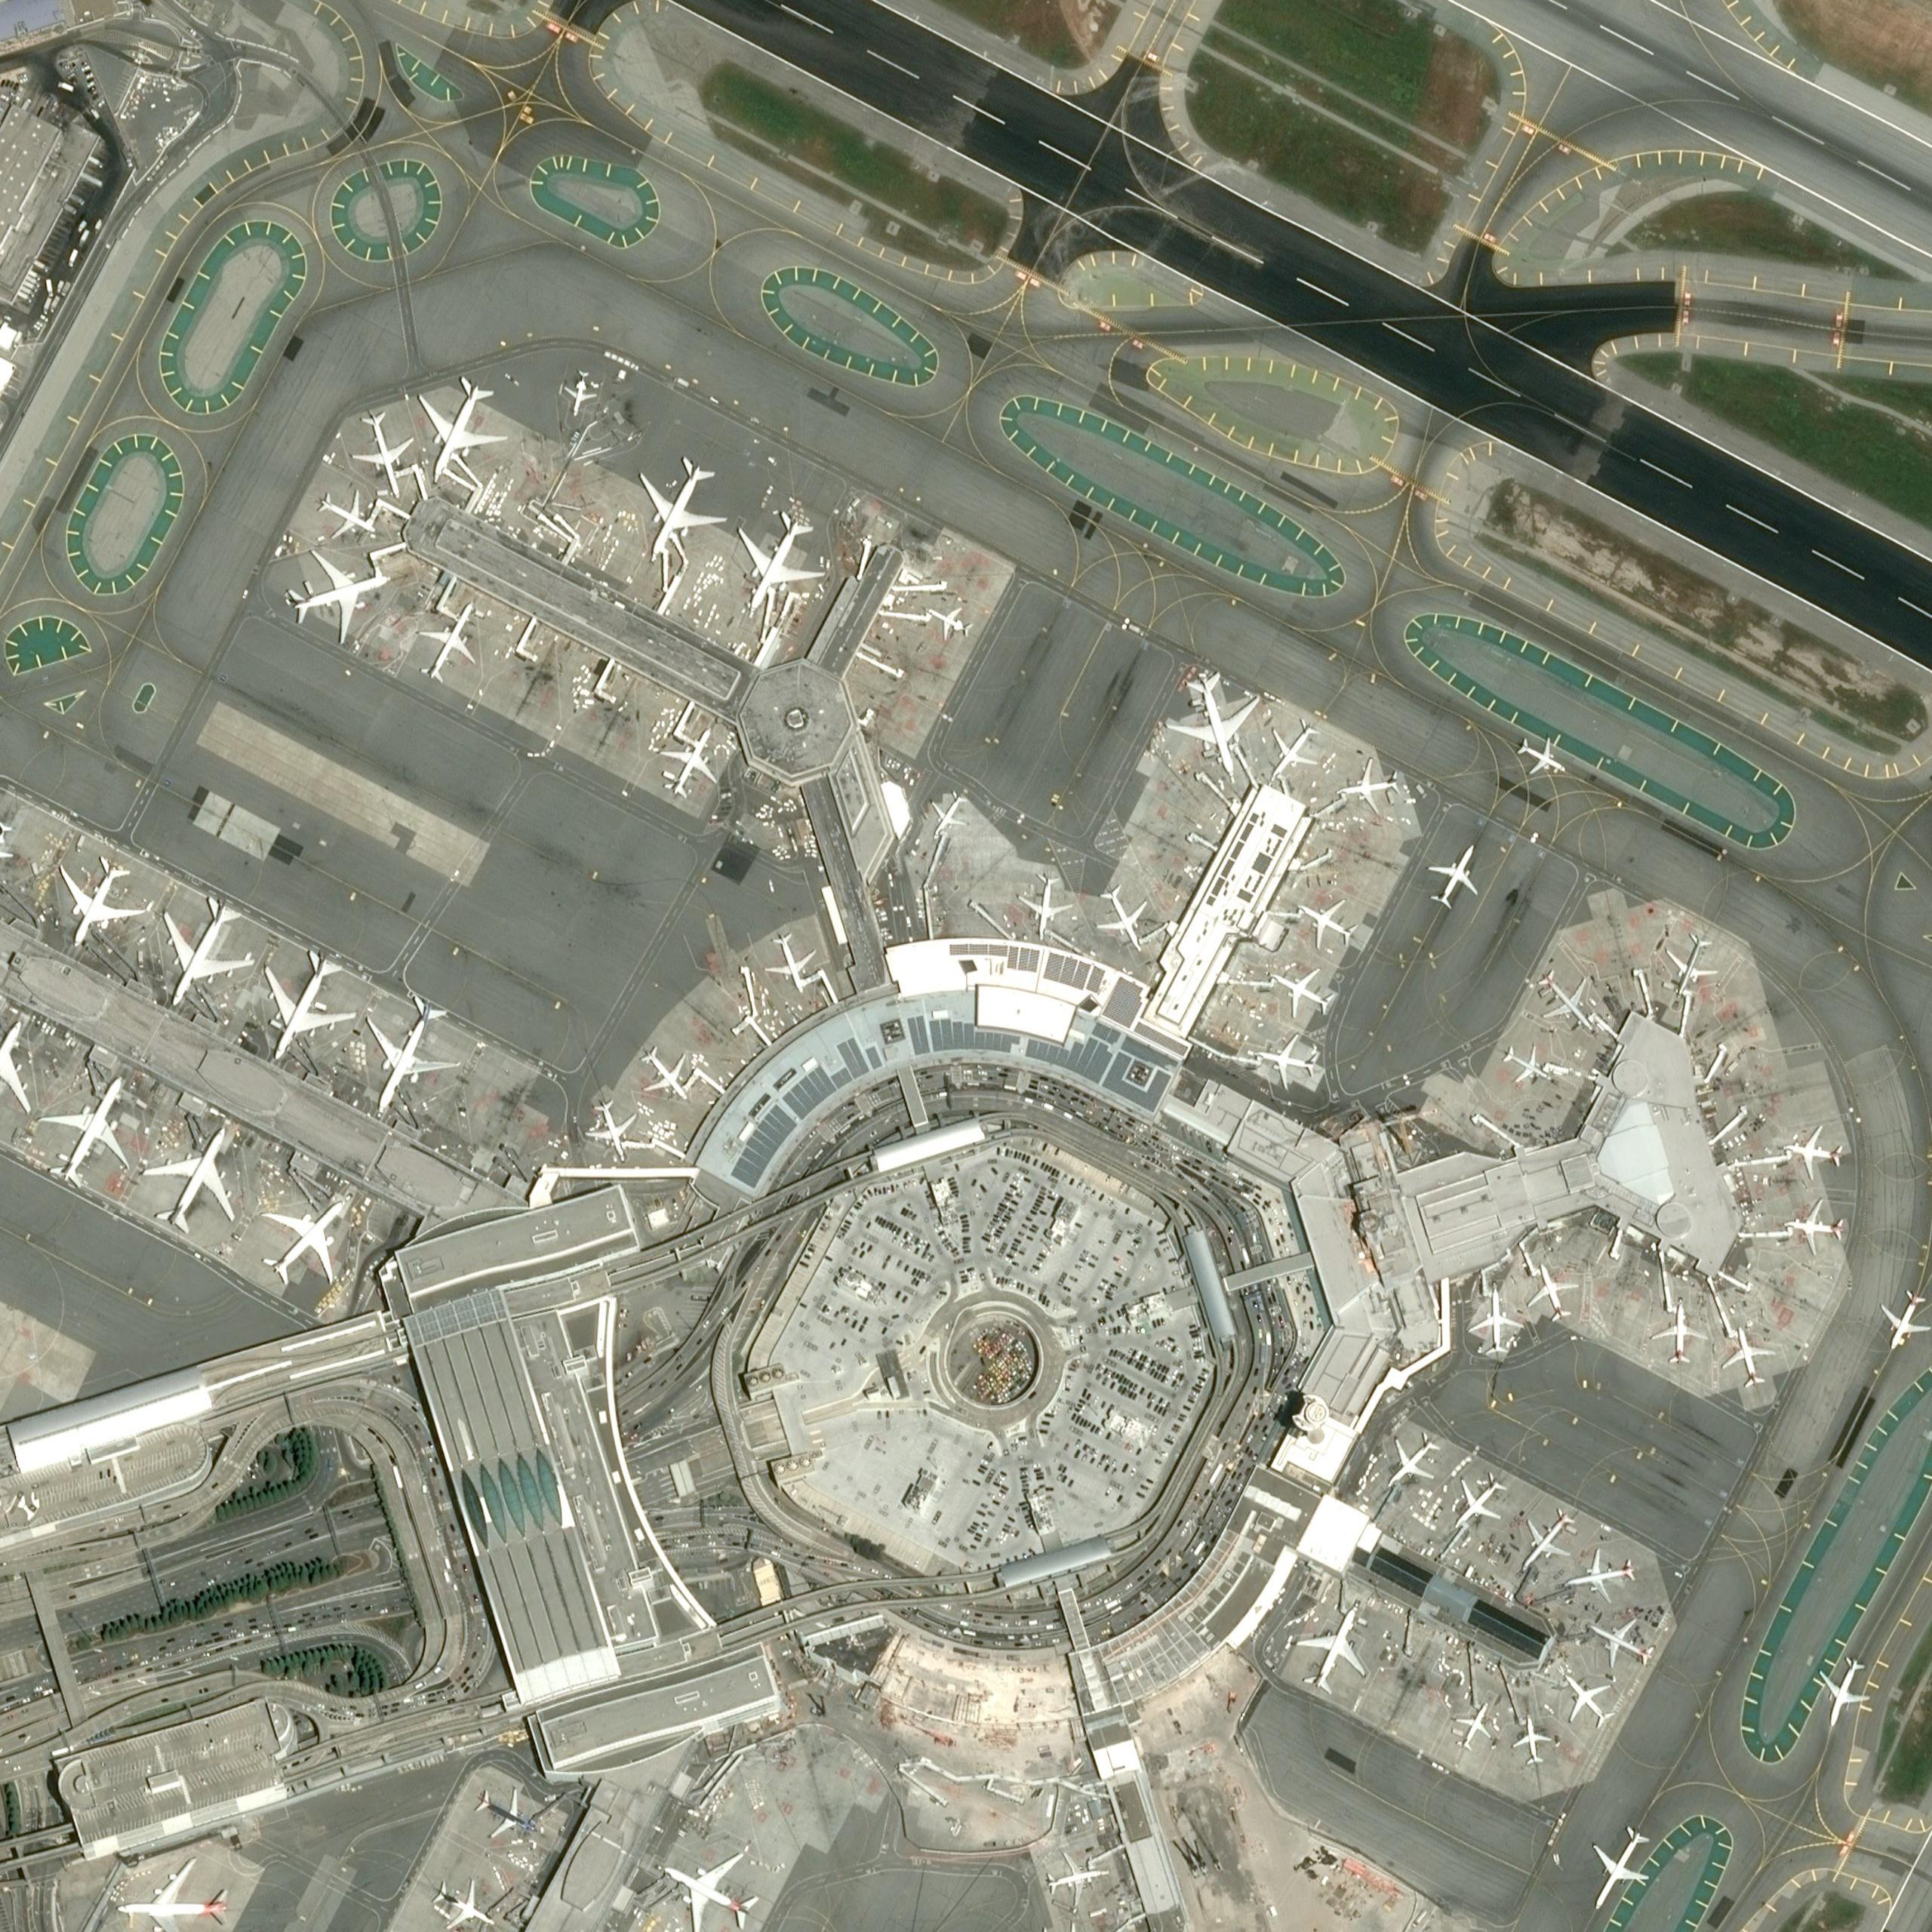

Sample tile: 696b9320-7dbe-4c28-bd07-7a73e7a28e64.jpg | resolution: 2560x2560


In [3]:
img_list = sorted(DATASET_DIR.glob("images/*.jpg"))
sample_path = random.choice(img_list)
with Image.open(sample_path) as img:
    width, height = img.size

display.display(display.Image(filename=str(sample_path), embed=True))
print(f"Sample tile: {sample_path.name} | resolution: {width}x{height}")

## Annotation parsing

Load the CSV annotations, convert polygons to bounding boxes, and attach helper columns needed for EDA/training.


In [4]:
ANNOTATIONS_PATH = DATASET_DIR / "annotations.csv"

CLASS_NAME_MAP = {
    "Airplane": "Aircraft",
    "Truncated_airplane": "Truncated_Aircraft",
}
CLASS_TO_IDX = {"Background": 0, "Aircraft": 1, "Truncated_Aircraft": 2}
IDX_TO_CLASS = {idx: name for name, idx in CLASS_TO_IDX.items()}


def parse_geometry(raw_value: str) -> List[Tuple[float, float]]:
    return ast.literal_eval(raw_value.rstrip("\r\n"))


df = pd.read_csv(ANNOTATIONS_PATH, converters={"geometry": parse_geometry})


def polygon_to_bounds(polygon: List[Tuple[float, float]]) -> Tuple[float, float, float, float]:
    arr = np.array(polygon, dtype=np.float32)
    xs, ys = arr[:, 0], arr[:, 1]
    return float(xs.min()), float(ys.min()), float(xs.max()), float(ys.max())


df[["xmin", "ymin", "xmax", "ymax"]] = df["geometry"].apply(
    lambda poly: pd.Series(polygon_to_bounds(poly))
)

df["width"] = df["xmax"] - df["xmin"]
df["height"] = df["ymax"] - df["ymin"]
df["area"] = df["width"] * df["height"]
df["aspect_ratio"] = df["width"] / df["height"]
df["image_path"] = df["image_id"].apply(lambda x: DATASET_DIR / "images" / x)
df["class_name"] = df["class"].map(CLASS_NAME_MAP).fillna("Aircraft")
df["label_id"] = df["class_name"].map(CLASS_TO_IDX).astype(int)

display_df = df.head(5).copy()
display_df["image_path"] = display_df["image_path"].astype(str)
display_df


,id,image_id,geometry,class,xmin,ymin,xmax,ymax,width,height,area,aspect_ratio,image_path,class_name,label_id
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Airplane,135.0,522.0,245.0,600.0,110.0,78.0,8580.0,1.410256,dataset/airbus-aircrafts-sample-dataset/images...,Aircraft,1
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Airplane,1025.0,284.0,1125.0,384.0,100.0,100.0,10000.0,1.000000,dataset/airbus-aircrafts-sample-dataset/images...,Aircraft,1
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Airplane,1058.0,1503.0,1130.0,1568.0,72.0,65.0,4680.0,1.107692,dataset/airbus-aircrafts-sample-dataset/images...,Aircraft,1
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Airplane,813.0,1518.0,885.0,1604.0,72.0,86.0,6192.0,0.837209,dataset/airbus-aircrafts-sample-dataset/images...,Aircraft,1
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Airplane,594.0,938.0,657.0,1012.0,63.0,74.0,4662.0,0.851351,dataset/airbus-aircrafts-sample-dataset/images...,Aircraft,1


## Exploratory data analysis

Understand how many aircraft exist per tile and how their bounding boxes are distributed before training.


,Unique tiles,Total boxes,Mean boxes/tile,Max boxes/tile,Min boxes/tile
0,103,3425,33.25,92,5


class_name
Aircraft              3316
Truncated_Aircraft     109
Name: count, dtype: int64

,image_id,median_width,median_height,median_area,box_count
85,d9399a45-6745-4e59-8903-90640b2ddf9f.jpg,96.0,101.0,9696.00,92
80,cbd51501-ed0f-411c-b472-df4357cca40c.jpg,67.5,67.0,4522.50,88
36,56e2d3d3-6b16-401f-a300-847272373df5.jpg,69.0,73.0,5037.00,71
60,980b5831-43b7-4adb-9e4b-67d6cff3ef68.jpg,69.0,78.0,5382.00,67
34,54b4e42b-3667-4564-b8fa-c23122ca54d5.jpg,69.0,69.0,4761.00,67
61,996ba764-cd2a-49c0-9c9f-b166207de0ab.jpg,89.5,70.5,6309.75,64
50,7635d63c-6b97-4c9c-a7dc-27773d42ed4c.jpg,110.5,129.5,14309.75,60
100,fc1ab8ce-e531-46ed-b74b-0374cd58cf2a.jpg,113.5,112.5,12768.75,58
45,696b9320-7dbe-4c28-bd07-7a73e7a28e64.jpg,77.5,83.5,6471.25,58
21,3e321b8a-9504-45aa-82b4-16158e28e290.jpg,80.0,83.0,6640.00,57


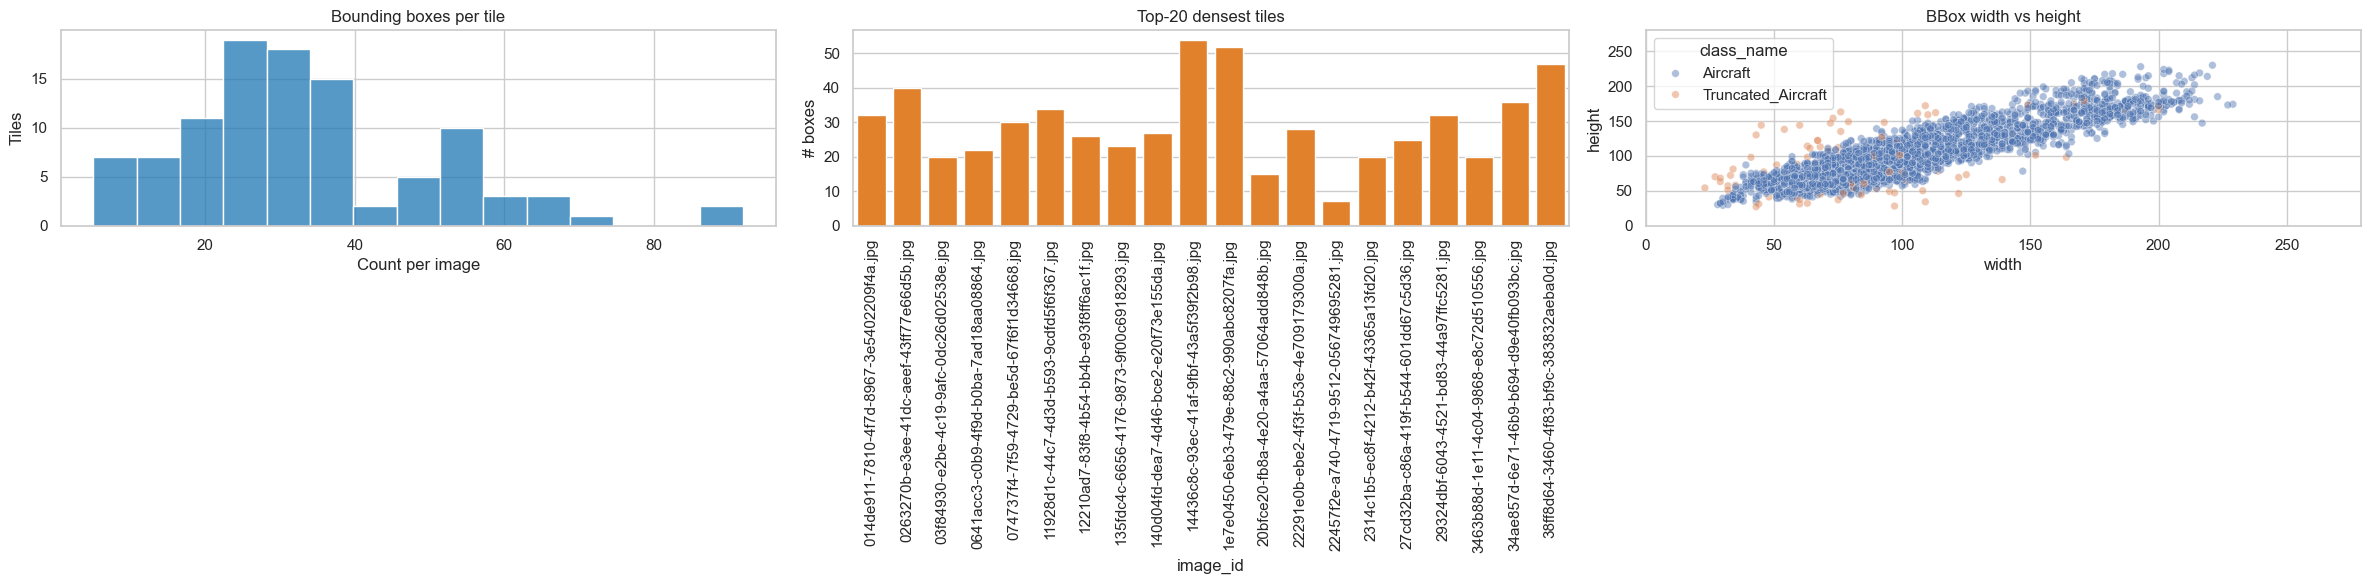

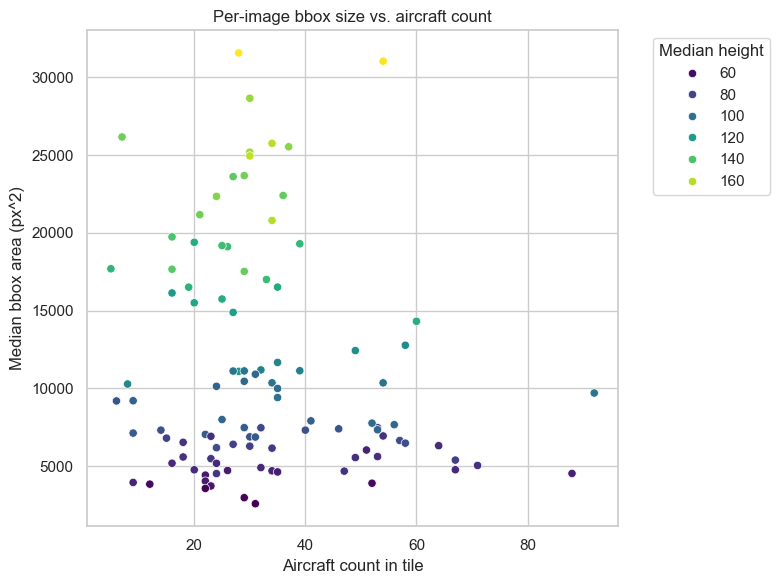

In [5]:
sns.set_theme(style="whitegrid")

num_images = df["image_id"].nunique()
boxes_per_image = df.groupby("image_id").size().astype(int)
class_distribution = df["class_name"].value_counts().rename("count")

summary_table = pd.DataFrame(
    {
        "Unique tiles": [num_images],
        "Total boxes": [len(df)],
        "Mean boxes/tile": [boxes_per_image.mean()],
        "Max boxes/tile": [boxes_per_image.max()],
        "Min boxes/tile": [boxes_per_image.min()],
    }
)
display.display(summary_table.round(2))

display.display(class_distribution)

per_image_box_stats = (
    df.groupby("image_id")
    .agg(
        box_count=("id", "count"),
        min_width=("width", "min"),
        median_width=("width", "median"),
        max_width=("width", "max"),
        min_height=("height", "min"),
        median_height=("height", "median"),
        max_height=("height", "max"),
    )
    .reset_index()
)
per_image_box_stats["median_area"] = per_image_box_stats["median_width"] * per_image_box_stats["median_height"]

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
sns.histplot(boxes_per_image, bins=15, ax=axes[0], color="#1f77b4")
axes[0].set_title("Bounding boxes per tile")
axes[0].set_xlabel("Count per image")
axes[0].set_ylabel("Tiles")

head_counts = boxes_per_image.head(20)
sns.barplot(x=head_counts.index, y=head_counts.values, ax=axes[1], color="#ff7f0e")
axes[1].set_title("Top-20 densest tiles")
axes[1].set_xlabel("image_id")
axes[1].tick_params(axis="x", rotation=90)
axes[1].set_ylabel("# boxes")

sns.scatterplot(
    data=df,
    x="width",
    y="height",
    hue="class_name",
    ax=axes[2],
    alpha=0.45,
    s=30,
)
axes[2].set_title("BBox width vs height")
axes[2].set_xlim(0, df["width"].max() + 50)
axes[2].set_ylim(0, df["height"].max() + 50)
plt.tight_layout()

per_image_melt = per_image_box_stats[["image_id", "median_width", "median_height", "median_area", "box_count"]].copy()
per_image_melt.sort_values("box_count", ascending=False, inplace=True)
display.display(per_image_melt.head(10))

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=per_image_box_stats,
    x="box_count",
    y="median_area",
    hue="median_height",
    palette="viridis",
)
plt.title("Per-image bbox size vs. aircraft count")
plt.xlabel("Aircraft count in tile")
plt.ylabel("Median bbox area (px^2)")
plt.legend(title="Median height", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()


## AlexNet backbone diagnostics

Instantiate a fresh AlexNet feature extractor, count its parameters, and trace the tensor shapes flowing through each major layer to double-check the architecture.


## Helper utilities for the training pipeline

Reusable dataset, augmentation, metric, and training helpers live in this section so the later notebook cells can stay focused on orchestration.


In [ ]:
# --- Dataset + utility structures -------------------------------------------------

@dataclass
class AnnotationRecord:
    """Container for all annotations belonging to one satellite tile."""

    image_id: str
    image_path: Path
    boxes: np.ndarray
    labels: np.ndarray
    class_names: List[str]


def build_annotation_records(frame: pd.DataFrame) -> Dict[str, AnnotationRecord]:
    records: Dict[str, AnnotationRecord] = {}
    for image_id, group in frame.groupby("image_id"):
        boxes = group[["xmin", "ymin", "xmax", "ymax"]].values.astype(np.float32)
        labels = group["label_id"].values.astype(np.int64)
        class_names = group["class_name"].tolist()
        image_path = Path(group["image_path"].iloc[0])
        records[image_id] = AnnotationRecord(
            image_id=image_id,
            image_path=image_path,
            boxes=boxes,
            labels=labels,
            class_names=class_names,
        )
    return records


def split_image_ids(
    image_ids: Sequence[str], val_ratio: float = 0.15, test_ratio: float = 0.15, seed: int = 42
) -> Dict[str, List[str]]:
    rng = np.random.default_rng(seed)
    image_ids = np.array(image_ids)
    rng.shuffle(image_ids)
    n_total = len(image_ids)
    n_test = int(n_total * test_ratio)
    n_val = int(n_total * val_ratio)
    test_ids = image_ids[:n_test].tolist()
    val_ids = image_ids[n_test : n_test + n_val].tolist()
    train_ids = image_ids[n_test + n_val :].tolist()
    return {"train": train_ids, "val": val_ids, "test": test_ids}


ALEXNET_WEIGHTS = AlexNet_Weights.IMAGENET1K_V1
ALEXNET_MEAN = ALEXNET_WEIGHTS.transforms().mean
ALEXNET_STD = ALEXNET_WEIGHTS.transforms().std


class AirbusDetectionDataset(Dataset):
    """PyTorch dataset that reads Airbus tiles and formats targets for Faster R-CNN."""

    def __init__(
        self,
        records: Dict[str, AnnotationRecord],
        image_ids: Sequence[str],
        image_size: int = 1024,
        is_train: bool = False,
        hflip_prob: float = 0.5,
    ) -> None:
        self.records = records
        self.image_ids = list(image_ids)
        self.image_size = image_size
        self.is_train = is_train
        self.hflip_prob = hflip_prob

    def __len__(self) -> int:
        return len(self.image_ids)

    def _load_image(self, record: AnnotationRecord) -> Image.Image:
        return Image.open(record.image_path).convert("RGB")

    def _resize_boxes(
        self, boxes: torch.Tensor, orig_size: Tuple[int, int], new_size: int
    ) -> torch.Tensor:
        orig_w, orig_h = orig_size
        scale_x = new_size / orig_w
        scale_y = new_size / orig_h
        boxes = boxes.clone()
        boxes[:, [0, 2]] *= scale_x
        boxes[:, [1, 3]] *= scale_y
        return boxes

    def _random_horizontal_flip(
        self, image: Image.Image, boxes: torch.Tensor
    ) -> Tuple[Image.Image, torch.Tensor]:
        if not self.is_train or random.random() > self.hflip_prob:
            return image, boxes
        flipped = image.transpose(Image.FLIP_LEFT_RIGHT)
        img_w = image.width
        boxes = boxes.clone()
        xmin = img_w - boxes[:, 2]
        xmax = img_w - boxes[:, 0]
        boxes[:, 0], boxes[:, 2] = xmin, xmax
        return flipped, boxes

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        record = self.records[self.image_ids[idx]]
        image = self._load_image(record)
        orig_w, orig_h = image.size

        boxes = torch.as_tensor(record.boxes, dtype=torch.float32)
        labels = torch.as_tensor(record.labels, dtype=torch.int64)

        if self.image_size:
            image = image.resize((self.image_size, self.image_size), Image.BILINEAR)
            boxes = self._resize_boxes(boxes, (orig_w, orig_h), self.image_size)

        image, boxes = self._random_horizontal_flip(image, boxes)

        tensor_image = F.to_tensor(image)
        tensor_image = F.normalize(tensor_image, mean=ALEXNET_MEAN, std=ALEXNET_STD)

        target: Dict[str, torch.Tensor] = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx], dtype=torch.int64),
            "area": (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]),
            "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64),
            "orig_size": torch.tensor([orig_h, orig_w]),
        }
        return tensor_image, target


def detection_collate(batch: Sequence[Tuple[torch.Tensor, Dict[str, torch.Tensor]]]):
    images, targets = zip(*batch)
    return list(images), list(targets)


# --- Training/evaluation helpers -------------------------------------------------

def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


class AverageMeter:
    """Track running averages for training losses."""

    def __init__(self) -> None:
        self.reset()

    def reset(self) -> None:
        self.count = 0
        self.total = 0.0

    def update(self, value: float, n: int = 1) -> None:
        self.total += value * n
        self.count += n

    @property
    def avg(self) -> float:
        return self.total / max(self.count, 1)


class EarlyStopping:
    def __init__(self, patience: int = 3, delta: float = 0.0) -> None:
        self.patience = patience
        self.delta = delta
        self.best_score: Optional[float] = None
        self.bad_epochs = 0

    def step(self, metric: float) -> bool:
        if self.best_score is None or metric > self.best_score + self.delta:
            self.best_score = metric
            self.bad_epochs = 0
            return False
        self.bad_epochs += 1
        return self.bad_epochs > self.patience


class CheckpointManager:
    def __init__(self, path: Path) -> None:
        self.path = path

    def save(self, model_state: Dict[str, Any], optimizer_state: Dict[str, Any], epoch: int, metric: float) -> None:
        torch.save(
            {
                "epoch": epoch,
                "metric": metric,
                "model_state": model_state,
                "optimizer_state": optimizer_state,
            },
            self.path,
        )


class HistoryLogger:
    def __init__(self) -> None:
        self.rows: List[Dict[str, float]] = []

    def log(self, **kwargs: float) -> None:
        self.rows.append(kwargs)

    def to_frame(self) -> pd.DataFrame:
        return pd.DataFrame(self.rows)


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> float:
    model.train()
    loss_meter = AverageMeter()
    for images, targets in tqdm(loader, desc="Train", leave=False):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        loss_meter.update(loss.item(), n=len(images))
    return loss_meter.avg


def validate_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
) -> float:
    prev_state = model.training
    model.train()
    loss_meter = AverageMeter()
    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Val", leave=False):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            loss = sum(loss_dict.values())
            loss_meter.update(loss.item(), n=len(images))
    model.train(prev_state)
    return loss_meter.avg


# --- Metric helpers --------------------------------------------------------------

def average_precision_50(
    pred_boxes: torch.Tensor,
    pred_scores: torch.Tensor,
    gt_boxes: torch.Tensor,
    iou_threshold: float = 0.5,
) -> float:
    if gt_boxes.numel() == 0:
        return 1.0 if pred_boxes.numel() == 0 else 0.0
    if pred_boxes.numel() == 0:
        return 0.0

    order = torch.argsort(pred_scores, descending=True)
    pred_boxes = pred_boxes[order]
    pred_scores = pred_scores[order]

    ious = box_iou(pred_boxes, gt_boxes)
    gt_matched = torch.zeros(len(gt_boxes), dtype=torch.bool)

    tps = []
    fps = []
    for pred_idx in range(len(pred_boxes)):
        iou_vals = ious[pred_idx]
        best_iou, best_gt = torch.max(iou_vals, dim=0)
        if best_iou >= iou_threshold and not gt_matched[best_gt]:
            gt_matched[best_gt] = True
            tps.append(1)
            fps.append(0)
        else:
            tps.append(0)
            fps.append(1)

    tps = np.cumsum(tps)
    fps = np.cumsum(fps)
    precisions = tps / np.maximum(tps + fps, 1e-6)
    recalls = tps / len(gt_boxes)
    ap = np.trapz(precisions, recalls)
    return float(ap)


def evaluate_detector(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    score_threshold: float = 0.4,
    iou_threshold: float = 0.5,
) -> Dict[str, float]:
    model.train(False)
    aps = []
    precisions = []
    recalls = []
    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Eval", leave=False):
            images = [img.to(device) for img in images]
            outputs = model(images)
            for output, target in zip(outputs, targets):
                keep = output["scores"] >= score_threshold
                pred_boxes = output["boxes"][keep].cpu()
                pred_scores = output["scores"][keep].cpu()
                gt_boxes = target["boxes"].cpu()
                ap = average_precision_50(pred_boxes, pred_scores, gt_boxes, iou_threshold)
                aps.append(ap)

                ious = box_iou(pred_boxes, gt_boxes) if pred_boxes.numel() and gt_boxes.numel() else torch.zeros((len(pred_boxes), len(gt_boxes)))
                matches = (ious >= iou_threshold).any(dim=1).sum().item() if gt_boxes.numel() else 0
                precisions.append(matches / max(len(pred_boxes), 1))
                recalls.append(matches / max(len(gt_boxes), 1))
    return {
        "mAP@0.5": float(np.mean(aps)) if aps else 0.0,
        "precision": float(np.mean(precisions)) if precisions else 0.0,
        "recall": float(np.mean(recalls)) if recalls else 0.0,
    }



In [12]:
temp_backbone = AlexNetFeatureBackbone(weights=ALEXNET_WEIGHTS, trainable_layers=2)
total_params = sum(p.numel() for p in temp_backbone.parameters())
trainable_params = sum(p.numel() for p in temp_backbone.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

layer_shapes: List[Dict[str, Any]] = []
hooks = []
TEST_INPUT_RES = 512


def record_hook(name: str):
    def hook(module, inputs, output):
        if isinstance(output, torch.Tensor):
            shape = tuple(output.shape)
        elif isinstance(output, (list, tuple)):
            shape = [tuple(o.shape) for o in output if isinstance(o, torch.Tensor)]
        else:
            shape = type(output).__name__
        layer_shapes.append({"layer": name, "type": module.__class__.__name__, "output_shape": shape})

    return hook


for name, module in temp_backbone.named_modules():
    if name and isinstance(module, (nn.Conv2d, nn.MaxPool2d, nn.AdaptiveAvgPool2d, nn.ReLU)):
        hooks.append(module.register_forward_hook(record_hook(name)))

with torch.no_grad():
    dummy = torch.zeros(1, 3, TEST_INPUT_RES, TEST_INPUT_RES)
    _ = temp_backbone(dummy)

for hook in hooks:
    hook.remove()

summary_df = pd.DataFrame(layer_shapes)
display.display(summary_df)



Total parameters: 2,469,696
Trainable parameters: 0


,layer,type,output_shape
0,body.0,Conv2d,"(1, 64, 127, 127)"
1,body.1,ReLU,"(1, 64, 127, 127)"
2,body.2,MaxPool2d,"(1, 64, 63, 63)"
3,body.3,Conv2d,"(1, 192, 63, 63)"
4,body.4,ReLU,"(1, 192, 63, 63)"
5,body.5,MaxPool2d,"(1, 192, 31, 31)"
6,body.6,Conv2d,"(1, 384, 31, 31)"
7,body.7,ReLU,"(1, 384, 31, 31)"
8,body.8,Conv2d,"(1, 256, 31, 31)"
9,body.9,ReLU,"(1, 256, 31, 31)"


## Train/validation/test splits and loaders

Create per-image records, stratify them into splits, and wrap everything with PyTorch dataloaders.


In [11]:
seed_everything(42)

records = build_annotation_records(df)
image_ids = sorted(records.keys())
splits = split_image_ids(image_ids, val_ratio=0.2, test_ratio=0.1, seed=42)

IMAGE_SIZE = 1024
BATCH_SIZE = 2
NUM_WORKERS = 0

train_dataset = AirbusDetectionDataset(records, splits["train"], image_size=IMAGE_SIZE, is_train=True)
val_dataset = AirbusDetectionDataset(records, splits["val"], image_size=IMAGE_SIZE, is_train=False)
test_dataset = AirbusDetectionDataset(records, splits["test"], image_size=IMAGE_SIZE, is_train=False)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=detection_collate,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=detection_collate,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=detection_collate,
)

split_summary = {
    split: {
        "tiles": len(ids),
        "boxes": sum(len(records[i].boxes) for i in ids),
    }
    for split, ids in splits.items()
}
pd.DataFrame(split_summary).T


,tiles,boxes
train,73,2429
val,20,691
test,10,305


## Training the AlexNet detector with Optuna

Use Optuna to explore optimizer settings (learning rate, weight decay, optimizer type), train for a handful of epochs with early stopping, and log/visualize the history.


In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

MAX_EPOCHS = 6
N_TRIALS = 2
PATIENCE = 2
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
BEST_MODEL_PATH = ARTIFACT_DIR / "alexnet_detector_best.pth"

best_trial_store = {"metric": -np.inf, "history": None, "params": None}


def build_model_instance() -> nn.Module:
    return build_alexnet_detector(num_classes=len(CLASS_TO_IDX))


def make_optimizer(trial: optuna.Trial, model: nn.Module) -> torch.optim.Optimizer:
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "AdamW"])
    lr = trial.suggest_float("lr", 1e-5, 3e-4, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    if optimizer_name == "SGD":
        return torch.optim.SGD(
            model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay, nesterov=True
        )
    return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)


def objective(trial: optuna.Trial) -> float:
    model = build_model_instance().to(device)
    optimizer = make_optimizer(trial, model)
    early_stopper = EarlyStopping(patience=PATIENCE, delta=1e-3)
    history = HistoryLogger()
    checkpoint_path = ARTIFACT_DIR / f"trial_{trial.number}_best.pth"
    checkpoint = CheckpointManager(checkpoint_path)
    best_metric = -np.inf

    for epoch in range(1, MAX_EPOCHS + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        val_loss = validate_one_epoch(model, val_loader, device)
        val_metrics = evaluate_detector(model, val_loader, device)
        metric = val_metrics["mAP@0.5"]

        history.log(
            epoch=epoch,
            train_loss=train_loss,
            val_loss=val_loss,
            map50=val_metrics["mAP@0.5"],
            precision=val_metrics["precision"],
            recall=val_metrics["recall"],
        )

        if metric > best_metric:
            best_metric = metric
            checkpoint.save(model.state_dict(), optimizer.state_dict(), epoch, metric)

        trial.report(metric, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if early_stopper.step(metric):
            print(f"Early stopping triggered on epoch {epoch}")
            break

    global best_trial_store
    if best_metric > best_trial_store["metric"]:
        best_trial_store["metric"] = best_metric
        best_trial_store["history"] = history.to_frame()
        best_trial_store["params"] = trial.params
        shutil.copy(checkpoint_path, BEST_MODEL_PATH)

    return best_metric


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=N_TRIALS)

print("Best trial:", study.best_trial.number)
print("Best params:", study.best_params)
print("Best mAP@0.5:", study.best_value)

best_history_df = best_trial_store["history"] if best_trial_store["history"] is not None else pd.DataFrame()
best_history_df


[I 2025-11-27 17:58:45,392] A new study created in memory with name: no-name-46135133-aadb-4d7b-8dc5-a2743b1dea97


Using device: mps


Train:   0%|          | 0/37 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

[W 2025-11-27 18:51:03,575] Trial 0 failed with parameters: {'optimizer': 'AdamW', 'lr': 0.00017722659754424477, 'weight_decay': 0.0004612102254281018} because of the following error: AttributeError("'list' object has no attribute 'values'").
Traceback (most recent call last):
  File "/Users/f1ol/workspace/ukma/NNs/LAB2/myenv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/7m/qdsdrmqn3f16kb2t7g07r2dw0000gn/T/ipykernel_62466/619548880.py", line 45, in objective
    val_loss = validate_one_epoch(model, val_loader, device)
  File "/var/folders/7m/qdsdrmqn3f16kb2t7g07r2dw0000gn/T/ipykernel_62466/1699440155.py", line 238, in validate_one_epoch
    loss = sum(loss_dict.values())
AttributeError: 'list' object has no attribute 'values'
[W 2025-11-27 18:51:03,586] Trial 0 failed with value None.


AttributeError: 'list' object has no attribute 'values'

### Training history visualization

Plot the logged loss curves and validation metrics for the best Optuna trial.


In [ ]:
if best_history_df.empty:
    print("History is empty. Run the Optuna training cell first.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].plot(best_history_df["epoch"], best_history_df["train_loss"], label="train loss")
    axes[0].plot(best_history_df["epoch"], best_history_df["val_loss"], label="val loss")
    axes[0].set_title("Loss curves")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    axes[1].plot(best_history_df["epoch"], best_history_df["map50"], label="mAP@0.5")
    axes[1].plot(best_history_df["epoch"], best_history_df["precision"], label="precision")
    axes[1].plot(best_history_df["epoch"], best_history_df["recall"], label="recall")
    axes[1].set_title("Validation metrics")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")
    axes[1].legend()
    plt.tight_layout()
    plt.show()


## Evaluation on held-out data

Load the best Optuna checkpoint and compute detection metrics on the validation and test splits.


In [ ]:
if not BEST_MODEL_PATH.exists():
    raise FileNotFoundError("Training has not produced a checkpoint yet — run the Optuna cell above.")

checkpoint = torch.load(BEST_MODEL_PATH, map_location=device)
best_model = build_model_instance()
best_model.load_state_dict(checkpoint["model_state"])
best_model.to(device)

val_metrics = evaluate_detector(best_model, val_loader, device)
test_metrics = evaluate_detector(best_model, test_loader, device)

metrics_df = pd.DataFrame([val_metrics, test_metrics], index=["val", "test"])
metrics_df


## Test-time inference visualization

Compare predicted and ground-truth bounding boxes on a random test tile. Predictions are shown in red with objectness scores, and ground truth in green.


In [ ]:
if "best_model" not in globals():
    if not BEST_MODEL_PATH.exists():
        raise FileNotFoundError("No trained model found. Run the training/eval cells first.")
    checkpoint = torch.load(BEST_MODEL_PATH, map_location=device)
    best_model = build_model_instance()
    best_model.load_state_dict(checkpoint["model_state"])
    best_model.to(device)

best_model.eval()

sample_image_id = random.choice(splits["test"])
sample_record = records[sample_image_id]
raw_image = Image.open(sample_record.image_path).convert("RGB")
orig_w, orig_h = raw_image.size

input_tensor = raw_image.resize((IMAGE_SIZE, IMAGE_SIZE), Image.BILINEAR)
input_tensor = F.to_tensor(input_tensor)
input_tensor = F.normalize(input_tensor, mean=ALEXNET_MEAN, std=ALEXNET_STD).unsqueeze(0).to(device)

with torch.no_grad():
    prediction = best_model(input_tensor)[0]

keep = prediction["scores"] >= 0.4
pred_boxes = prediction["boxes"][keep].cpu().clone()
pred_scores = prediction["scores"][keep].cpu().tolist()
pred_labels = prediction["labels"][keep].cpu().tolist()

scale_x = orig_w / IMAGE_SIZE
scale_y = orig_h / IMAGE_SIZE
pred_boxes[:, [0, 2]] *= scale_x
pred_boxes[:, [1, 3]] *= scale_y

pred_vis = raw_image.copy()
draw_pred = ImageDraw.Draw(pred_vis)
for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
    box = box.tolist()
    draw_pred.rectangle(box, outline="red", width=3)
    class_name = IDX_TO_CLASS.get(label, "Aircraft")
    draw_pred.text((box[0] + 4, box[1] + 4), f"{class_name} {score:.2f}", fill="red")

gt_vis = raw_image.copy()
draw_gt = ImageDraw.Draw(gt_vis)
for box, label in zip(sample_record.boxes, sample_record.labels):
    box = box.tolist()
    draw_gt.rectangle(box, outline="green", width=3)
    class_name = IDX_TO_CLASS.get(int(label), "Aircraft")
    draw_gt.text((box[0] + 4, box[1] + 4), class_name, fill="green")

print(f"Sample test tile: {sample_image_id}")
display.display(pred_vis)
display.display(gt_vis)
